In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
from scipy.stats import spearmanr
import os

In [161]:
# ===============================================================
# 🏆 INDIVIDUAL AWARDS PREDICTION — DATA PREPARATION
# ===============================================================

# ===============================================================
# 1️⃣ Load Data
# ===============================================================
players = pd.read_csv("data/players.csv")
players_teams = pd.read_csv("data/players_teams.csv")
awards = pd.read_csv("data/awards_players.csv")
teams = pd.read_csv("data/teams.csv")

# ===============================================================
# 2️⃣ Filter to main awards only
# ===============================================================
main_awards = [
    'Most Valuable Player',
    'Defensive Player of the Year',
    'Rookie of the Year',
    'Most Improved Player',
    'All-Star Game Most Valuable Player',
    'WNBA Finals Most Valuable Player'
]
awards_main = awards[awards['award'].isin(main_awards)]

print(f"Total awards: {len(awards_main)}")
print(awards_main['award'].value_counts())

# ===============================================================
# 3️⃣ Create player performance features
# ===============================================================
player_stats = players_teams.copy()

# filter players with significant playing time (>= 10 games)
player_stats = player_stats[player_stats['GP'] >= 10]

# per-game statistics
player_stats['ppg'] = player_stats['points'] / player_stats['GP']
player_stats['rpg'] = player_stats['rebounds'] / player_stats['GP']
player_stats['apg'] = player_stats['assists'] / player_stats['GP']
player_stats['spg'] = player_stats['steals'] / player_stats['GP']
player_stats['bpg'] = player_stats['blocks'] / player_stats['GP']
player_stats['mpg'] = player_stats['minutes'] / player_stats['GP']

# shooting efficiency
player_stats['fg_pct'] = np.where(
    player_stats['fgAttempted'] > 0,
    player_stats['fgMade'] / player_stats['fgAttempted'],
    0
)

# simple efficiency rating
player_stats['efficiency'] = (
    player_stats['points'] + player_stats['rebounds'] + 
    player_stats['assists'] + player_stats['steals'] + 
    player_stats['blocks'] - player_stats['turnovers']
) / player_stats['GP']

# games started percentage
player_stats['gs_pct'] = player_stats['GS'] / player_stats['GP']

# ===============================================================
# 3️⃣b NEW: Add cumulative/historical features
# ===============================================================
print("\n// Creating cumulative features (career trajectory)...")
player_stats = player_stats.sort_values(['playerID', 'year'])

cumulative_cols = ['ppg', 'rpg', 'apg', 'spg', 'bpg', 'efficiency', 'mpg', 'fg_pct']

for col in cumulative_cols:
    player_stats[f'{col}_cumulative'] = 0.0
    player_stats[f'{col}_prev'] = np.nan

for player_id in player_stats['playerID'].unique():
    player_mask = player_stats['playerID'] == player_id
    player_years = player_stats[player_mask].sort_values('year')
    
    for col in cumulative_cols:
        cumulative_values = []
        prev_cumulative = 0.0
        
        for idx, (_, row) in enumerate(player_years.iterrows()):
            current_value = row[col]
            cumulative_value = current_value * 1.0 + prev_cumulative * 0.4
            cumulative_values.append(cumulative_value)
            prev_cumulative = cumulative_value
        
        player_stats.loc[player_mask, f'{col}_cumulative'] = cumulative_values
        
        player_stats.loc[player_mask, f'{col}_prev'] = player_stats.loc[player_mask, col].shift(1)

# ===============================================================
# 4️⃣ Add team success metrics
# ===============================================================
teams_success = teams[['year', 'tmID', 'won', 'lost', 'confID', 'playoff']].copy()
teams_success['win_pct'] = teams_success['won'] / (teams_success['won'] + teams_success['lost'])
teams_success['made_playoffs'] = teams_success['playoff'].notna().astype(int)

# add conference rank (important for awards context)
teams_success['conf_rank'] = teams_success.groupby(['year', 'confID'])['win_pct'].rank(ascending=False)

player_stats = player_stats.merge(teams_success[['year', 'tmID', 'win_pct', 'made_playoffs', 'conf_rank']], 
                                   on=['year', 'tmID'], how='left')

# ===============================================================
# 4️⃣a Add playoff performance metrics (for Finals MVP)
# ===============================================================
teams_post = pd.read_csv("data/teams_post.csv")
teams_post['playoff_wins'] = teams_post['W']
teams_post['playoff_losses'] = teams_post['L']
teams_post['playoff_games'] = teams_post['W'] + teams_post['L']
teams_post['playoff_win_pct'] = teams_post['W'] / teams_post['playoff_games']

# Championship indicator (teams with 6+ playoff wins likely won championship)
teams_post['won_championship'] = (teams_post['playoff_wins'] >= 6).astype(int)

# Reached finals (teams with 4+ playoff wins)
teams_post['reached_finals'] = (teams_post['playoff_wins'] >= 4).astype(int)

player_stats = player_stats.merge(
    teams_post[['year', 'tmID', 'playoff_wins', 'playoff_losses', 'playoff_games', 
                'playoff_win_pct', 'won_championship', 'reached_finals']], 
    on=['year', 'tmID'], 
    how='left'
)

# fill NaN values for teams that didn't make playoffs
player_stats['playoff_wins'] = player_stats['playoff_wins'].fillna(0)
player_stats['playoff_losses'] = player_stats['playoff_losses'].fillna(0)
player_stats['playoff_games'] = player_stats['playoff_games'].fillna(0)
player_stats['playoff_win_pct'] = player_stats['playoff_win_pct'].fillna(0)
player_stats['won_championship'] = player_stats['won_championship'].fillna(0)
player_stats['reached_finals'] = player_stats['reached_finals'].fillna(0)

# ===============================================================
# 4️⃣b Add league-wide comparative metrics
# ===============================================================
# Calculate league averages per year
yearly_avg = player_stats.groupby('year').agg({
    'ppg': 'mean',
    'rpg': 'mean',
    'apg': 'mean',
    'spg': 'mean',
    'bpg': 'mean',
    'efficiency': 'mean'
}).add_suffix('_league_avg').reset_index()

player_stats = player_stats.merge(yearly_avg, on='year', how='left')

# create comparative features (how much better than average)
player_stats['ppg_vs_avg'] = player_stats['ppg'] - player_stats['ppg_league_avg']
player_stats['rpg_vs_avg'] = player_stats['rpg'] - player_stats['rpg_league_avg']
player_stats['apg_vs_avg'] = player_stats['apg'] - player_stats['apg_league_avg']
player_stats['efficiency_vs_avg'] = player_stats['efficiency'] - player_stats['efficiency_league_avg']

# ===============================================================
# 5️⃣ Identify rookies (first year players)
# ===============================================================
player_stats = player_stats.sort_values(['playerID', 'year'])
player_stats['is_rookie'] = player_stats.groupby('playerID').cumcount() == 0
player_stats['is_rookie'] = player_stats['is_rookie'].astype(int)

# ===============================================================
# 5️⃣b NEW: Add years of experience
# ===============================================================
player_stats['years_experience'] = player_stats.groupby('playerID').cumcount()

# ===============================================================
# 6️⃣ Create target variables for each award
# ===============================================================
for award in main_awards:
    col_name = f"won_{award.replace(' ', '_').lower()}"
    player_stats[col_name] = 0
    
    for _, row in awards_main[awards_main['award'] == award].iterrows():
        mask = (player_stats['playerID'] == row['playerID']) & \
               (player_stats['year'] == row['year'])
        player_stats.loc[mask, col_name] = 1

# ===============================================================
# 6️⃣b NEW: Add award history features (momentum effect)
# ===============================================================
print("\n// Creating award history features (momentum effect)...")
player_stats = player_stats.sort_values(['playerID', 'year'])

for award in main_awards:
    col_name = f"won_{award.replace(' ', '_').lower()}"
    prev_col_name = f"prev_{award.replace(' ', '_').lower()}"
    
    player_stats[prev_col_name] = player_stats.groupby('playerID')[col_name].shift(1).fillna(0)

# total previous awards (any award)
award_cols = [f"won_{award.replace(' ', '_').lower()}" for award in main_awards]
player_stats['total_previous_awards'] = 0
for col in award_cols:
    player_stats['total_previous_awards'] += player_stats.groupby('playerID')[col].cumsum().shift(1).fillna(0)

# years since last award
player_stats['years_since_last_award'] = 0
for player_id in player_stats['playerID'].unique():
    player_mask = player_stats['playerID'] == player_id
    player_years = player_stats[player_mask].sort_values('year')
    
    years_since = []
    last_award_year = -999
    
    for _, row in player_years.iterrows():
        # check if player won any award this year
        won_award = any([row[col] == 1 for col in award_cols])
        
        if won_award:
            years_since.append(0)
            last_award_year = row['year']
        else:
            if last_award_year == -999:
                years_since.append(99)  # never won an award
            else:
                years_since.append(row['year'] - last_award_year)
    
    player_stats.loc[player_mask, 'years_since_last_award'] = years_since

# cap years_since_last_award at 10 for interpretability
player_stats['years_since_last_award'] = player_stats['years_since_last_award'].clip(upper=10)

# ===============================================================
# 7️⃣ Fill missing values
# ===============================================================
player_stats['win_pct'] = player_stats['win_pct'].fillna(0.5)
player_stats['made_playoffs'] = player_stats['made_playoffs'].fillna(0)
player_stats['conf_rank'] = player_stats['conf_rank'].fillna(8)  # middle of conference
for col in ['ppg_vs_avg', 'rpg_vs_avg', 'apg_vs_avg', 'efficiency_vs_avg']:
    player_stats[col] = player_stats[col].fillna(0)

# fill missing cumulative/previous values for rookies
for col in cumulative_cols:
    player_stats[f'{col}_cumulative'] = player_stats[f'{col}_cumulative'].fillna(player_stats[col])
    player_stats[f'{col}_prev'] = player_stats[f'{col}_prev'].fillna(0)

# ===============================================================
# 8️⃣ Save prepared dataset
# ===============================================================
os.makedirs("data_models", exist_ok=True)
player_stats.to_csv("data_models/awards_dataset.csv", index=False)

print("\n✅ Dataset ready: data_models/awards_dataset.csv")
print(f"Shape: {player_stats.shape}")
print("\nAward winners distribution:")
for award in main_awards:
    col_name = f"won_{award.replace(' ', '_').lower()}"
    winners = player_stats[col_name].sum()
    print(f"{award}: {winners} winners")

print("\n// NEW FEATURES SUMMARY:")
print(f"Cumulative features: {len(cumulative_cols)} stats with career trajectory")
print(f"Award history features: total_previous_awards, years_since_last_award, individual prev_* flags")
print(f"Experience feature: years_experience")
print(f"Total features: {len(player_stats.columns)} columns")


Total awards: 57
award
Defensive Player of the Year          10
Most Valuable Player                  10
WNBA Finals Most Valuable Player      10
Rookie of the Year                    10
Most Improved Player                   9
All-Star Game Most Valuable Player     8
Name: count, dtype: int64

// Creating cumulative features (career trajectory)...

// Creating award history features (momentum effect)...

// Creating award history features (momentum effect)...

✅ Dataset ready: data_models/awards_dataset.csv
Shape: (1603, 103)

Award winners distribution:
Most Valuable Player: 10 winners
Defensive Player of the Year: 10 winners
Rookie of the Year: 10 winners
Most Improved Player: 9 winners
All-Star Game Most Valuable Player: 8 winners
WNBA Finals Most Valuable Player: 10 winners

// NEW FEATURES SUMMARY:
Cumulative features: 8 stats with career trajectory
Award history features: total_previous_awards, years_since_last_award, individual prev_* flags
Experience feature: years_experience


Treino: (1296, 103) | Teste (9): (162, 103)

MVP winners in training: 8
MVP winners in test: 1
Class balance: 8/1296 = 0.62%
Total features: 30 (including 10 new historical features)

// MVP Ranking Evaluation for year 9:
Actual winner rank: 1 out of 162
Actual winner probability: 0.425
Top-1 prediction: ✓ CORRECT
Top-3 prediction: ✓ CORRECT
Top-5 prediction: ✓ CORRECT
Top-10 prediction: ✓ CORRECT
Mean Reciprocal Rank: 1.0000
Spearman Rank Correlation: 0.3970 (p=0.0000)

// Baseline Comparison:
Baseline strategy: Rank by efficiency
  Baseline model ranks winner at: #2
  Our model ranks winner at: #1
  Improvement: 1 positions better

// Top 10 MVP candidates:
        playerID tmID        ppg   win_pct  made_playoffs  mvp_proba  \
1053  parkeca01w  LAS  18.484848  0.588235              1   0.425000   
1361  tauradi01w  PHO  24.117647  0.470588              1   0.154969   
629   jacksla01w  SEA  20.238095  0.647059              1   0.085000   
780   leslili01w  LAS  15.060606  0.588235  

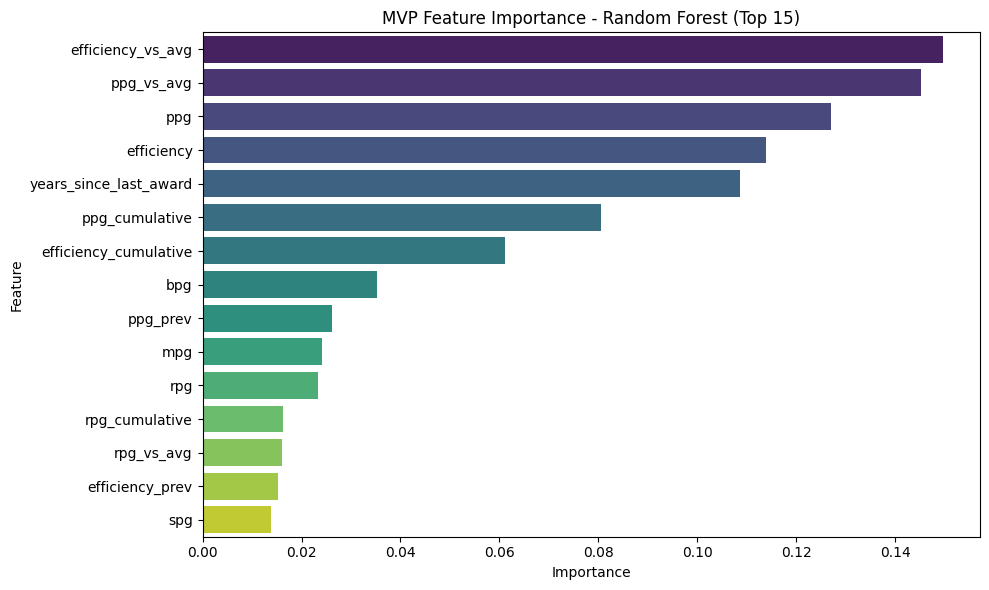


// Top 10 Most Important Features:
                   Feature  Importance
17       efficiency_vs_avg    0.149620
14              ppg_vs_avg    0.145119
0                      ppg    0.126912
7               efficiency    0.113885
27  years_since_last_award    0.108552
18          ppg_cumulative    0.080445
21   efficiency_cumulative    0.061167
4                      bpg    0.035247
23                ppg_prev    0.026248
5                      mpg    0.024106

// New Historical Features Impact:
Total importance of new features: 0.218
                  Feature  Importance
18         ppg_cumulative    0.080445
21  efficiency_cumulative    0.061167
23               ppg_prev    0.026248
19         rpg_cumulative    0.016346
24        efficiency_prev    0.015248


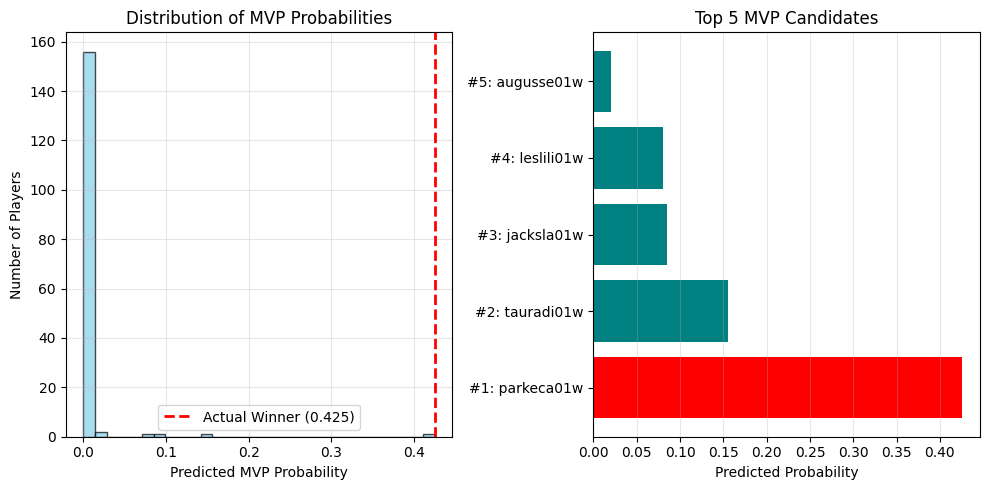


// Results saved to: data_models/predictions_mvp.csv


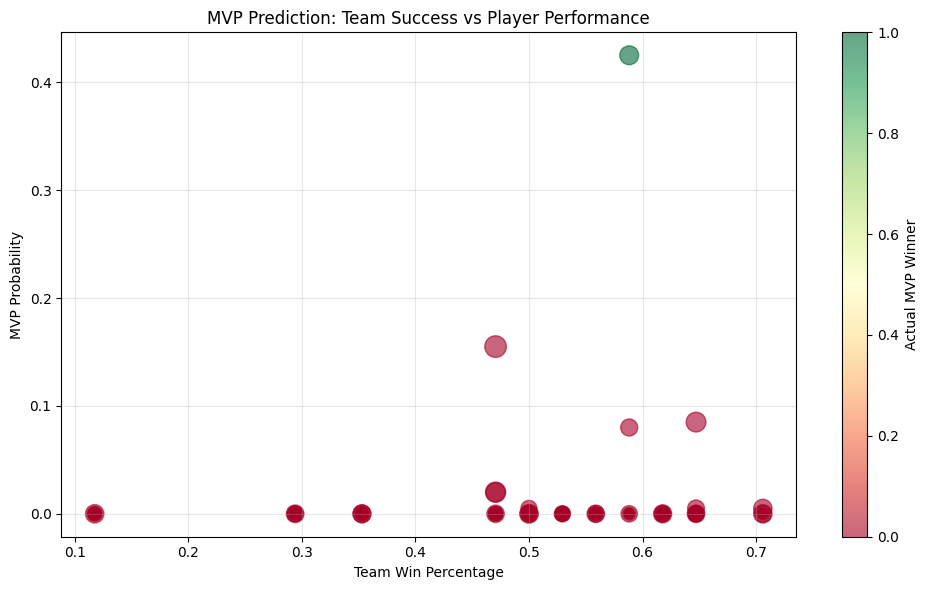

In [ ]:
# ===============================================================
# 🏀 MVP PREDICTION — MODEL & EVALUATION (WITH NEW FEATURES)
# ===============================================================

# ===============================================================
# 1️⃣ Load prepared dataset
# ===============================================================
player_df = pd.read_csv("data_models/awards_dataset.csv")

# ===============================================================
# 2️⃣ Choose target year
# ===============================================================
target_year = 9
train_data = player_df[player_df["year"] < target_year]
test_data = player_df[player_df["year"] == target_year]

print(f"Treino: {train_data.shape} | Teste ({target_year}): {test_data.shape}")

# ===============================================================
# 3️⃣ Define features and target for MVP (WITH NEW FEATURES)
# ===============================================================
features = [
    # current year performance
    'ppg', 'rpg', 'apg', 'spg', 'bpg', 'mpg',
    'fg_pct', 'efficiency', 'gs_pct', 'win_pct', 'GP', 'GS',
    'made_playoffs', 'conf_rank', 
    
    # comparative to league average
    'ppg_vs_avg', 'rpg_vs_avg', 'apg_vs_avg', 'efficiency_vs_avg',
    
    # cumulative/historical features (career trajectory)
    'ppg_cumulative', 'rpg_cumulative', 'apg_cumulative', 
    'efficiency_cumulative', 'mpg_cumulative',
    
    # previous year performance
    'ppg_prev', 'efficiency_prev', 'mpg_prev',
    
    # award history (momentum effect)
    'total_previous_awards', 'years_since_last_award',
    'prev_most_valuable_player',
    
    # experience
    'years_experience'
]
target = 'won_most_valuable_player'

x_train = train_data[features]
y_train = train_data[target]
x_test = test_data[features]
y_test = test_data[target]

print(f"\nMVP winners in training: {y_train.sum()}")
print(f"MVP winners in test: {y_test.sum()}")
print(f"Class balance: {y_train.sum()}/{len(y_train)} = {y_train.sum()/len(y_train)*100:.2f}%")
print(f"Total features: {len(features)} (including {len([f for f in features if 'cumulative' in f or 'prev' in f or 'previous' in f])} new historical features)")

# ===============================================================
# 4️⃣ Train Random Forest model
# ===============================================================
model_mvp = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
model_mvp.fit(x_train, y_train)

# ===============================================================
# 5️⃣ Predictions
# ===============================================================
test_data = test_data.copy()
test_data.loc[:, 'mvp_proba'] = model_mvp.predict_proba(x_test)[:, 1]
test_data.loc[:, 'mvp_rank'] = test_data['mvp_proba'].rank(ascending=False, method='first')

# ===============================================================
# 6️⃣ Evaluation
# ===============================================================
winner_rank = None
winner_proba = None
actual_winner_id = None

# for awards, what matters is: is the winner in our top predictions?
actual_winner_id_array = test_data[test_data[target] == 1]['playerID'].values
if len(actual_winner_id_array) > 0:
    actual_winner_id = actual_winner_id_array[0]
    winner_rank = test_data[test_data['playerID'] == actual_winner_id]['mvp_rank'].values[0]
    winner_proba = test_data[test_data['playerID'] == actual_winner_id]['mvp_proba'].values[0]
    
    print(f"\n// MVP Ranking Evaluation for year {target_year}:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_data)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
    print(f"Top-10 prediction: {'✓ CORRECT' if winner_rank <= 10 else '✗ INCORRECT'}")
    
    # mean reciprocal rank
    mrr = 1.0 / winner_rank
    print(f"Mean Reciprocal Rank: {mrr:.4f}")
    
    # spearman correlation between predicted probabilities and actual winner
    # create binary actual ranking (1 for winner, 0 for others)
    test_data['actual_winner'] = (test_data['playerID'] == actual_winner_id).astype(int)
    spearman_corr, spearman_p = spearmanr(-test_data['mvp_proba'], test_data['mvp_rank'])
    print(f"Spearman Rank Correlation: {spearman_corr:.4f} (p={spearman_p:.4f})")
else:
    print("\nNo MVP winner in test set")

# ===============================================================
# 6️⃣b Baseline Comparison
# ===============================================================
print("\n// Baseline Comparison:")
print("Baseline strategy: Rank by efficiency")
test_data['baseline_rank'] = test_data['efficiency'].rank(ascending=False, method='first')

if actual_winner_id is not None:
    baseline_winner_rank = test_data[test_data['playerID'] == actual_winner_id]['baseline_rank'].values[0]
    print(f"  Baseline model ranks winner at: #{int(baseline_winner_rank)}")
    print(f"  Our model ranks winner at: #{int(winner_rank)}")
    print(f"  Improvement: {int(baseline_winner_rank - winner_rank)} positions {'better' if winner_rank < baseline_winner_rank else 'worse'}")


# ===============================================================
# 7️⃣ Top MVP candidates
# ===============================================================
print("\n// Top 10 MVP candidates:")
top_mvp = test_data[[
    'playerID', 'tmID', 'ppg', 'rpg', 'apg', 'efficiency',
    'win_pct', 'made_playoffs', 'conf_rank',
    'mvp_proba', 'mvp_rank', 'won_most_valuable_player'
]].sort_values('mvp_proba', ascending=False).head(10)
print(top_mvp[['playerID', 'tmID', 'ppg', 'win_pct', 'made_playoffs', 'mvp_proba', 'mvp_rank', 'won_most_valuable_player']])

# ===============================================================
# 8️⃣ Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'Feature': features,
    'Importance': model_mvp.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
top_features = importance.head(15)
sns.barplot(data=top_features, x='Importance', y='Feature', hue='Feature', palette='base', legend=False)
plt.title('MVP Feature Importance - Random Forest (Top 15)')
plt.tight_layout()
plt.show()

print("\n// Top 10 Most Important Features:")
print(importance.head(10))

# check impact of new features
new_feature_importance = importance[importance['Feature'].str.contains('cumulative|prev|previous|experience', regex=True)]
if len(new_feature_importance) > 0:
    print(f"\n// New Historical Features Impact:")
    print(f"Total importance of new features: {new_feature_importance['Importance'].sum():.3f}")
    print(new_feature_importance.head())

# ===============================================================
# 8️⃣b️ Probability Distribution Analysis
# ===============================================================
plt.figure(figsize=(10, 5))

# left plot: distribution of predicted probabilities
plt.subplot(1, 2, 1)
plt.hist(test_data['mvp_proba'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
if winner_proba is not None:
    plt.axvline(winner_proba, color='red', linestyle='--', linewidth=2, label=f'Actual Winner ({winner_proba:.3f})')
plt.xlabel('Predicted MVP Probability')
plt.ylabel('Number of Players')
plt.title('Distribution of MVP Probabilities')
plt.legend()
plt.grid(alpha=0.3)

# right plot: top candidates probability comparison
plt.subplot(1, 2, 2)
top_5 = test_data.nsmallest(5, 'mvp_rank')
colors = ['red' if pid == actual_winner_id else 'teal' for pid in top_5['playerID']]
plt.barh(range(len(top_5)), top_5['mvp_proba'], color=colors)
plt.yticks(range(len(top_5)), [f"#{int(r)}: {pid}" for r, pid in zip(top_5['mvp_rank'], top_5['playerID'])])
plt.xlabel('Predicted Probability')
plt.title('Top 5 MVP Candidates')
plt.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


# ===============================================================
# 9️⃣ Save predictions
# ===============================================================
test_data.to_csv("data_models/predictions_mvp.csv", index=False)
print("\n// Results saved to: data_models/predictions_mvp.csv")

# ===============================================================
# 🔟 Analysis: Team Success vs MVP Probability
# ===============================================================
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    test_data['win_pct'], 
    test_data['mvp_proba'],
    c=test_data['won_most_valuable_player'],
    s=test_data['ppg']*10,
    alpha=0.6,
    cmap='RdYlGn'
)
plt.xlabel('Team Win Percentage')
plt.ylabel('MVP Probability')
plt.title('MVP Prediction: Team Success vs Player Performance')
plt.colorbar(scatter, label='Actual MVP Winner')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


DPOY winners in training: 8
DPOY winners in test: 1
Class balance: 8/1296 = 0.62%

// DPOY Ranking Evaluation for year 9:
Actual winner rank: 1 out of 162
Actual winner probability: 0.240
Top-1 prediction: ✓ CORRECT
Top-3 prediction: ✓ CORRECT
Top-5 prediction: ✓ CORRECT
Mean Reciprocal Rank: 1.0000

// Top 10 DPOY candidates:
        playerID tmID       spg       bpg   win_pct  dpoy_proba  dpoy_rank  \
780   leslili01w  LAS  1.484848  2.939394  0.588235    0.240000        1.0   
1053  parkeca01w  LAS  1.272727  2.272727  0.588235    0.120000        2.0   
574   hoffmeb01w  IND  1.424242  0.787879  0.500000    0.104959        3.0   
629   jacksla01w  SEA  1.476190  1.571429  0.647059    0.059996        4.0   
1271  smithka01w  DET  0.941176  0.088235  0.647059    0.029995        5.0   
1595  youngso01w  SAS  1.606061  0.515152  0.705882    0.025000        6.0   
240   catchta01w  IND  1.960000  0.440000  0.500000    0.005000        7.0   
1503  whaleli01w  CON  1.451613  0.032258  0.61

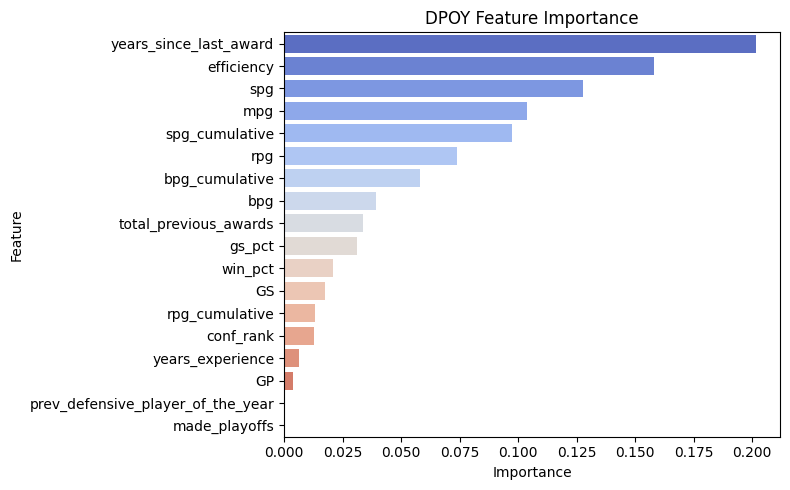


// Top 5 Most Important Features:
                   Feature  Importance
15  years_since_last_award    0.201764
4               efficiency    0.157838
0                      spg    0.127830
3                      mpg    0.103581
11          spg_cumulative    0.097559

// Results saved to: data_models/predictions_dpoy.csv


In [ ]:
# ===============================================================
# 🛡️ DEFENSIVE PLAYER OF THE YEAR — MODEL & EVALUATION
# ===============================================================

# ===============================================================
# 1️⃣ Load data (already prepared)
# ===============================================================
target_year = 9
train_data = player_df[player_df["year"] < target_year]
test_data = player_df[player_df["year"] == target_year]

# ===============================================================
# 2️⃣ Features focused on defense (ENHANCED)
# ===============================================================
features_dpoy = [
    # defensive stats
    'spg', 'bpg', 'rpg', 'mpg', 'efficiency',
    'gs_pct', 'win_pct', 'GP', 'GS',
    'made_playoffs', 'conf_rank',
    
    # cumulative defensive prowess
    'spg_cumulative', 'bpg_cumulative', 'rpg_cumulative',
    
    # award history (DPOY often repeat winners)
    'total_previous_awards', 'years_since_last_award',
    'prev_defensive_player_of_the_year',
    
    # experience
    'years_experience'
]
target = 'won_defensive_player_of_the_year'

x_train = train_data[features_dpoy]
y_train = train_data[target]
x_test = test_data[features_dpoy]
y_test = test_data[target]

print(f"DPOY winners in training: {y_train.sum()}")
print(f"DPOY winners in test: {y_test.sum()}")
print(f"Class balance: {y_train.sum()}/{len(y_train)} = {y_train.sum()/len(y_train)*100:.2f}%")

# ===============================================================
# 3️⃣ Train model
# ===============================================================
model_dpoy = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
model_dpoy.fit(x_train, y_train)

# ===============================================================
# 4️⃣ Predictions
# ===============================================================
test_data = test_data.copy()
test_data.loc[:, 'dpoy_proba'] = model_dpoy.predict_proba(x_test)[:, 1]
test_data.loc[:, 'dpoy_rank'] = test_data['dpoy_proba'].rank(ascending=False, method='first')

# ===============================================================
# 5️⃣ Evaluation
# ===============================================================
actual_winner_id_array = test_data[test_data[target] == 1]['playerID'].values
if len(actual_winner_id_array) > 0:
    actual_winner_id = actual_winner_id_array[0]
    winner_rank = test_data[test_data['playerID'] == actual_winner_id]['dpoy_rank'].values[0]
    winner_proba = test_data[test_data['playerID'] == actual_winner_id]['dpoy_proba'].values[0]
    
    print(f"\n// DPOY Ranking Evaluation for year {target_year}:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_data)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
    
    mrr = 1.0 / winner_rank
    print(f"Mean Reciprocal Rank: {mrr:.4f}")
else:
    print("\nNo DPOY winner in test set")

# ===============================================================
# 6️⃣ Top DPOY candidates
# ===============================================================
print("\n// Top 10 DPOY candidates:")
top_dpoy = test_data[[
    'playerID', 'tmID', 'spg', 'bpg', 'rpg',
    'win_pct', 'made_playoffs',
    'dpoy_proba', 'dpoy_rank', 'won_defensive_player_of_the_year'
]].sort_values('dpoy_proba', ascending=False).head(10)
print(top_dpoy[['playerID', 'tmID', 'spg', 'bpg', 'win_pct', 'dpoy_proba', 'dpoy_rank', 'won_defensive_player_of_the_year']])

# ===============================================================
# 7️⃣ Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'Feature': features_dpoy,
    'Importance': model_dpoy.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x='Importance', y='Feature', hue='Feature', palette='coolwarm', legend=False)
plt.title('DPOY Feature Importance')
plt.tight_layout()
plt.show()

print("\n// Top 5 Most Important Features:")
print(importance.head())

# ===============================================================
# 8️⃣ Save predictions
# ===============================================================
test_data.to_csv("data_models/predictions_dpoy.csv", index=False)
print("\n// Results saved to: data_models/predictions_dpoy.csv")

Rookie training data: (405, 103)
Rookie test data: (36, 103)

ROY winners in training: 8
ROY winners in test: 1
Class balance: 8/405 = 1.98%

// ROY Ranking Evaluation for year 9:
Actual winner rank: 2 out of 36
Actual winner probability: 0.104
Top-1 prediction: ✗ INCORRECT
Top-3 prediction: ✓ CORRECT
Top-5 prediction: ✓ CORRECT
Mean Reciprocal Rank: 0.5000

// Top 10 Rookie of the Year candidates:
        playerID tmID        ppg   win_pct  roy_proba  roy_rank  \
25    anosini01w  MIN   9.235294  0.470588   0.335489       1.0   
1053  parkeca01w  LAS  18.484848  0.588235   0.104051       2.0   
1528  wiggica01w  MIN  15.733333  0.470588   0.074971       3.0   
433   fowlesy01w  CHI  10.470588  0.352941   0.015000       4.0   
595   hornbal01w  DET   5.411765  0.647059   0.005000       5.0   
37    atunrmo01w  SAS   2.151515  0.705882   0.000000       8.0   
9     ajavoma01w  HOU   8.029412  0.500000   0.000000       6.0   
18    anderjo01w  CON   4.041667  0.617647   0.000000       7.

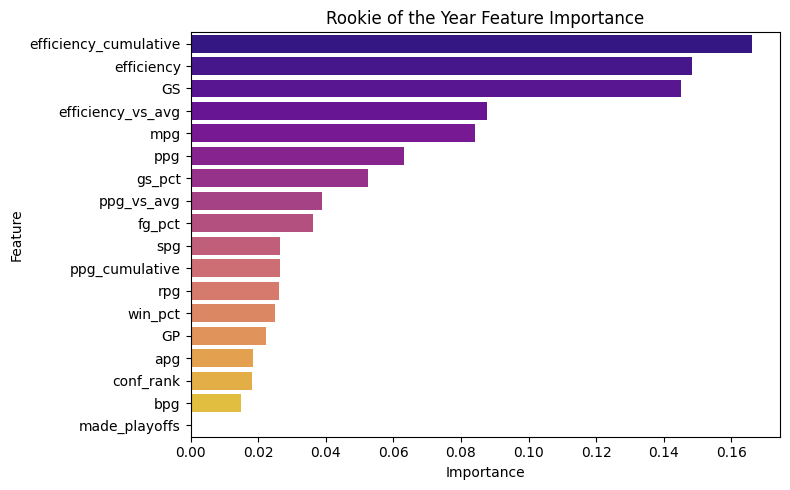


// Top 5 Most Important Features:
                  Feature  Importance
17  efficiency_cumulative    0.166088
7              efficiency    0.148406
10                     GS    0.145151
15      efficiency_vs_avg    0.087854
5                     mpg    0.084046

// Results saved to: data_models/predictions_roy.csv


In [ ]:
# ===============================================================
# 🌟 ROOKIE OF THE YEAR — MODEL & EVALUATION
# ===============================================================

# ===============================================================
# 1️⃣ Filter only rookies
# ===============================================================
target_year = 9
train_rookies = player_df[(player_df["year"] < target_year) & (player_df["is_rookie"] == 1)]
test_rookies = player_df[(player_df["year"] == target_year) & (player_df["is_rookie"] == 1)]

print(f"Rookie training data: {train_rookies.shape}")
print(f"Rookie test data: {test_rookies.shape}")

# ===============================================================
# 2️⃣ Features for rookies (ENHANCED)
# ===============================================================
features_roy = [
    # current performance
    'ppg', 'rpg', 'apg', 'spg', 'bpg', 'mpg',
    'fg_pct', 'efficiency', 'gs_pct', 'GP', 'GS',
    'win_pct', 'made_playoffs', 'conf_rank',
    
    # comparative metrics
    'ppg_vs_avg', 'efficiency_vs_avg',
    
    # cumulative features
    'ppg_cumulative', 'efficiency_cumulative'
]
target = 'won_rookie_of_the_year'

x_train = train_rookies[features_roy]
y_train = train_rookies[target]
x_test = test_rookies[features_roy]
y_test = test_rookies[target]

print(f"\nROY winners in training: {y_train.sum()}")
print(f"ROY winners in test: {y_test.sum()}")
print(f"Class balance: {y_train.sum()}/{len(y_train)} = {y_train.sum()/len(y_train)*100:.2f}%")

# ===============================================================
# 3️⃣ Train model
# ===============================================================
model_roy = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    class_weight='balanced'
)
model_roy.fit(x_train, y_train)

# ===============================================================
# 4️⃣ Predictions
# ===============================================================
test_rookies = test_rookies.copy()
test_rookies.loc[:, 'roy_proba'] = model_roy.predict_proba(x_test)[:, 1]
test_rookies.loc[:, 'roy_rank'] = test_rookies['roy_proba'].rank(ascending=False, method='first')

# ===============================================================
# 5️⃣ Evaluation
# ===============================================================
winner_rank = None
winner_proba = None

actual_winner_id_array = test_rookies[test_rookies[target] == 1]['playerID'].values
if len(actual_winner_id_array) > 0:
    actual_winner_id = actual_winner_id_array[0]
    winner_rank = test_rookies[test_rookies['playerID'] == actual_winner_id]['roy_rank'].values[0]
    winner_proba = test_rookies[test_rookies['playerID'] == actual_winner_id]['roy_proba'].values[0]
    
    print(f"\n// ROY Ranking Evaluation for year {target_year}:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_rookies)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
    
    mrr = 1.0 / winner_rank
    print(f"Mean Reciprocal Rank: {mrr:.4f}")
else:
    print("\nNo ROY winner in test set")

# ===============================================================
# 6️⃣ Top ROY candidates
# ===============================================================
print("\n// Top 10 Rookie of the Year candidates:")
top_roy = test_rookies[[
    'playerID', 'tmID', 'ppg', 'rpg', 'apg', 'efficiency',
    'win_pct', 'made_playoffs',
    'roy_proba', 'roy_rank', 'won_rookie_of_the_year'
]].sort_values('roy_proba', ascending=False).head(10)
print(top_roy[['playerID', 'tmID', 'ppg', 'win_pct', 'roy_proba', 'roy_rank', 'won_rookie_of_the_year']])

# ===============================================================
# 7️⃣ Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'Feature': features_roy,
    'Importance': model_roy.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x='Importance', y='Feature', hue='Feature', palette='plasma', legend=False)
plt.title('Rookie of the Year Feature Importance')
plt.tight_layout()
plt.show()

print("\n// Top 5 Most Important Features:")
print(importance.head())

# ===============================================================
# 8️⃣ Save predictions
# ===============================================================
test_rookies.to_csv("data_models/predictions_roy.csv", index=False)
print("\n// Results saved to: data_models/predictions_roy.csv")

MIP eligible training data: (891, 108)
MIP eligible test data: (126, 108)

MIP winners in training: 6
MIP winners in test: 1
Class balance: 6/891 = 0.67%
Total features: 19 (including cumulative trajectory features)

// MIP Ranking Evaluation for year 9:
Actual winner rank: 1 out of 126
Actual winner probability: 0.610
Top-1 prediction: ✓ CORRECT
Top-3 prediction: ✓ CORRECT
Top-5 prediction: ✓ CORRECT
Mean Reciprocal Rank: 1.0000

// Top 10 Most Improved Player candidates:
        playerID        ppg  ppg_improvement  efficiency_improvement  \
574   hoffmeb01w  10.363636         6.128342               10.877897   
749   lattaiv01w  11.411765         8.411765               12.641366   
1545  willile01w  10.088235         8.016807               11.346639   
318   desouer01w   9.333333         5.083333               10.333333   
793   littlca01w   9.736842         4.967611                6.117409   
672   johnssh01w   7.666667         1.818182                6.636364   
1073  perkiji01w  

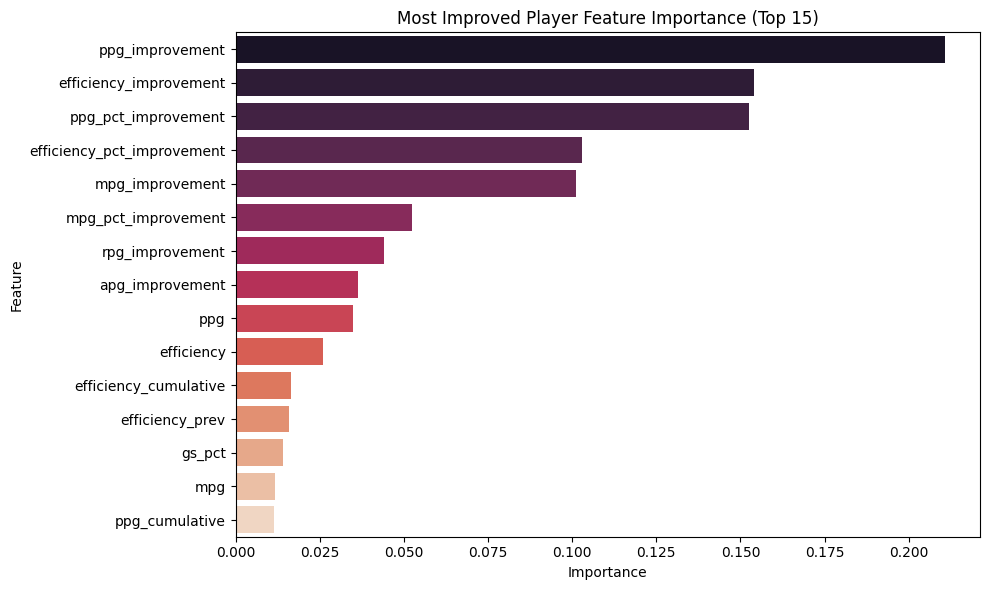


// Top 10 Most Important Features:
                      Feature  Importance
0             ppg_improvement    0.210641
3      efficiency_improvement    0.154144
5         ppg_pct_improvement    0.152432
6  efficiency_pct_improvement    0.103011
4             mpg_improvement    0.101226
7         mpg_pct_improvement    0.052576
1             rpg_improvement    0.044154
2             apg_improvement    0.036480
8                         ppg    0.034932
9                  efficiency    0.026072

// New Trajectory Features Impact:
Total importance: 0.029
                  Feature  Importance
14  efficiency_cumulative    0.016563
13         ppg_cumulative    0.011479
17       years_experience    0.000860
18  total_previous_awards    0.000044

// Results saved to: data_models/predictions_mip.csv


In [ ]:
# ===============================================================
# 💪 MOST IMPROVED PLAYER — MODEL & EVALUATION (ENHANCED)
# ===============================================================

# ===============================================================
# 1️⃣ Create improvement metrics
# ===============================================================
target_year = 9

# calculate year-over-year improvement for non-rookies
player_stats_sorted = player_df.sort_values(['playerID', 'year'])

# get current and previous year stats
improvement_cols = ['ppg', 'rpg', 'apg', 'efficiency', 'mpg']
for col in improvement_cols:
    player_stats_sorted[f'{col}_prev'] = player_stats_sorted.groupby('playerID')[col].shift(1)
    player_stats_sorted[f'{col}_improvement'] = player_stats_sorted[col] - player_stats_sorted[f'{col}_prev']

# filter to eligible players (not rookies, played previous year)
player_df_with_improvement = player_stats_sorted[player_stats_sorted['is_rookie'] == 0].copy()

# only consider players with improvement data
train_eligible = player_df_with_improvement[
    (player_df_with_improvement["year"] < target_year) & 
    (player_df_with_improvement['ppg_prev'].notna())
].copy()
test_eligible = player_df_with_improvement[
    (player_df_with_improvement["year"] == target_year) & 
    (player_df_with_improvement['ppg_prev'].notna())
].copy()

print(f"MIP eligible training data: {train_eligible.shape}")
print(f"MIP eligible test data: {test_eligible.shape}")

# ===============================================================
# 2️⃣ Features for Most Improved Player (ENHANCED)
# ===============================================================
# Create percentage improvement features (more meaningful than raw differences)
train_eligible['ppg_pct_improvement'] = (train_eligible['ppg'] - train_eligible['ppg_prev']) / (train_eligible['ppg_prev'] + 0.1)
train_eligible['efficiency_pct_improvement'] = (train_eligible['efficiency'] - train_eligible['efficiency_prev']) / (train_eligible['efficiency_prev'] + 0.1)
train_eligible['mpg_pct_improvement'] = (train_eligible['mpg'] - train_eligible['mpg_prev']) / (train_eligible['mpg_prev'] + 0.1)

test_eligible['ppg_pct_improvement'] = (test_eligible['ppg'] - test_eligible['ppg_prev']) / (test_eligible['ppg_prev'] + 0.1)
test_eligible['efficiency_pct_improvement'] = (test_eligible['efficiency'] - test_eligible['efficiency_prev']) / (test_eligible['efficiency_prev'] + 0.1)
test_eligible['mpg_pct_improvement'] = (test_eligible['mpg'] - test_eligible['mpg_prev']) / (test_eligible['mpg_prev'] + 0.1)

# note: MIP is about individual improvement - de-emphasize team success
features_mip = [
    # raw improvements
    'ppg_improvement', 'rpg_improvement', 'apg_improvement', 
    'efficiency_improvement', 'mpg_improvement',
    
    # percentage improvements
    'ppg_pct_improvement', 'efficiency_pct_improvement', 'mpg_pct_improvement',
    
    # current year performance (shows they're actually good nowww)
    'ppg', 'efficiency', 'mpg', 'GP',
    
    # minimal team context
    'gs_pct',
    
    # cumulative features show career trajectory
    'ppg_cumulative', 'efficiency_cumulative',
    
    # previous baseline to show where they came from
    'ppg_prev', 'efficiency_prev',
    
    # experience (because often 2nd-3rd year players win)
    'years_experience',
    
    # award history (previous winners unlikely to win MIP)
    'total_previous_awards'
]
target = 'won_most_improved_player'

x_train = train_eligible[features_mip]
y_train = train_eligible[target]
x_test = test_eligible[features_mip]
y_test = test_eligible[target]

print(f"\nMIP winners in training: {y_train.sum()}")
print(f"MIP winners in test: {y_test.sum()}")
print(f"Class balance: {y_train.sum()}/{len(y_train)} = {y_train.sum()/len(y_train)*100:.2f}%")
print(f"Total features: {len(features_mip)} (including cumulative trajectory features)")

# ===============================================================
# 3️⃣ Train model with adjusted hyperparameters for MIP
# ===============================================================
model_mip = RandomForestClassifier(
    n_estimators=400,
    max_depth=8,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',
    max_features='sqrt'
)
model_mip.fit(x_train, y_train)

# ===============================================================
# 4️⃣ Predictions
# ===============================================================
test_eligible = test_eligible.copy()
test_eligible.loc[:, 'mip_proba'] = model_mip.predict_proba(x_test)[:, 1]
test_eligible.loc[:, 'mip_rank'] = test_eligible['mip_proba'].rank(ascending=False, method='first')

# ===============================================================
# 5️⃣ Evaluation
# ===============================================================
actual_winner_id_array = test_eligible[test_eligible[target] == 1]['playerID'].values
if len(actual_winner_id_array) > 0:
    actual_winner_id = actual_winner_id_array[0]
    winner_rank = test_eligible[test_eligible['playerID'] == actual_winner_id]['mip_rank'].values[0]
    winner_proba = test_eligible[test_eligible['playerID'] == actual_winner_id]['mip_proba'].values[0]
    
    print(f"\n// MIP Ranking Evaluation for year {target_year}:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_eligible)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
    
    mrr = 1.0 / winner_rank
    print(f"Mean Reciprocal Rank: {mrr:.4f}")
else:
    print("\nNo MIP winner in test set")

# ===============================================================
# 6️⃣ Top MIP candidates
# ===============================================================
print("\n// Top 10 Most Improved Player candidates:")
top_mip = test_eligible[[
    'playerID', 'tmID', 'ppg', 'ppg_prev', 'ppg_improvement',
    'efficiency', 'efficiency_improvement', 'win_pct',
    'mip_proba', 'mip_rank', 'won_most_improved_player'
]].sort_values('mip_proba', ascending=False).head(10)
print(top_mip[['playerID', 'ppg', 'ppg_improvement', 'efficiency_improvement', 'mip_proba', 'mip_rank', 'won_most_improved_player']])

# ===============================================================
# 7️⃣ Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'Feature': features_mip,
    'Importance': model_mip.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance.head(15), x='Importance', y='Feature', hue='Feature', palette='rocket', legend=False)
plt.title('Most Improved Player Feature Importance (Top 15)')
plt.tight_layout()
plt.show()

print("\n// Top 10 Most Important Features:")
print(importance.head(10))

# check impact of cumulative features
cumulative_features = importance[importance['Feature'].str.contains('cumulative|experience|previous')]
if len(cumulative_features) > 0:
    print(f"\n// New Trajectory Features Impact:")
    print(f"Total importance: {cumulative_features['Importance'].sum():.3f}")
    print(cumulative_features)

# ===============================================================
# 8️⃣ Save predictions
# ===============================================================
test_eligible.to_csv("data_models/predictions_mip.csv", index=False)
print("\n// Results saved to: data_models/predictions_mip.csv")


All-Star MVP eligible training data: (318, 103)
All-Star MVP eligible test data: (42, 103)

All-Star MVP winners in training: 5
All-Star MVP winners in test: 0
Class balance: 5/318 = 1.57%

No All-Star MVP winner in test set

// Top 10 All-Star Game MVP candidates:
        playerID tmID        ppg       apg  efficiency  asg_proba  asg_rank  \
40    augusse01w  MIN  19.064516  2.677419   25.354839   0.210544       1.0   
780   leslili01w  LAS  15.060606  2.424242   27.181818   0.197858       2.0   
1073  perkiji01w  CHI  16.970588  2.823529   24.205882   0.183791       3.0   
1017  nolande01w  DET  15.823529  4.411765   23.529412   0.171622       4.0   
514   hammobe01w  SAS  17.636364  4.878788   23.636364   0.166618       5.0   
345   douglka01w  IND  15.636364  3.212121   21.848485   0.165603       6.0   
1098  pondeca01w  PHO  21.218750  4.218750   27.593750   0.146125       7.0   
701   jonesas01w  CON  17.000000  2.454545   24.696970   0.122565       8.0   
79    beardal01w  WAS  

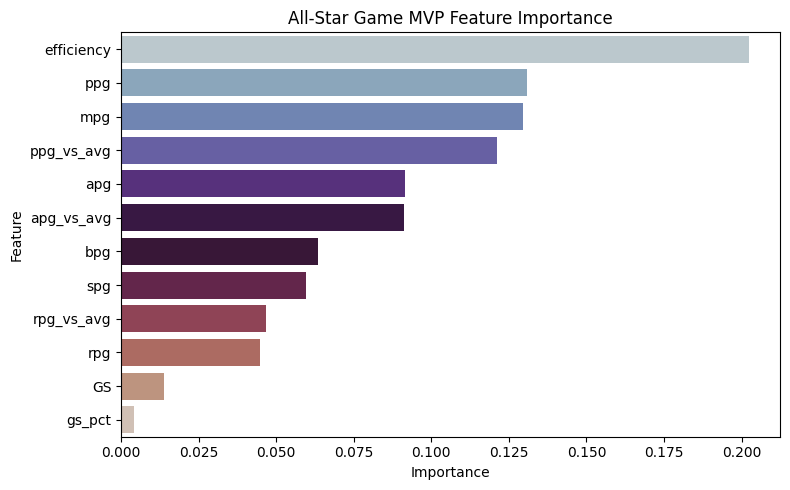


// Top 5 Most Important Features:
      Feature  Importance
5  efficiency    0.202281
0         ppg    0.130908
6         mpg    0.129546
7  ppg_vs_avg    0.121224
2         apg    0.091636

// Results saved to: data_models/predictions_asg.csv


In [ ]:
# ===============================================================
# ⭐ ALL-STAR GAME MVP — MODEL & EVALUATION
# ===============================================================

# ===============================================================
# 1️⃣ Filter to elite players (All-Star caliber)
# ===============================================================
target_year = 9

# All-Star MVP: focus on versatile players who can have big games
# need consistent high-level performance throughout season
train_allstar = player_df[
    (player_df["year"] < target_year) & 
    (player_df["is_rookie"] == 0) &  # not rookies
    (player_df["GP"] >= 25) &  # full season players
    (player_df["mpg"] >= 25) &  # starters/key players
    (player_df["efficiency"] >= 12)  # solid efficiency floor
].copy()
test_allstar = player_df[
    (player_df["year"] == target_year) & 
    (player_df["is_rookie"] == 0) &
    (player_df["GP"] >= 25) &
    (player_df["mpg"] >= 25) &
    (player_df["efficiency"] >= 12)
].copy()

print(f"All-Star MVP eligible training data: {train_allstar.shape}")
print(f"All-Star MVP eligible test data: {test_allstar.shape}")

# ===============================================================
# 2️⃣ Features for All-Star Game MVP
# ===============================================================
features_asg = [
    'ppg', 'rpg', 'apg', 'spg', 'bpg',  # all-around stats
    'efficiency', 'mpg',  # overall impact
    'ppg_vs_avg', 'rpg_vs_avg', 'apg_vs_avg',  # above-average contributions
    'GS', 'gs_pct'  # starter role
]
target = 'won_all-star_game_most_valuable_player'

x_train = train_allstar[features_asg]
y_train = train_allstar[target]
x_test = test_allstar[features_asg]
y_test = test_allstar[target]

print(f"\nAll-Star MVP winners in training: {y_train.sum()}")
print(f"All-Star MVP winners in test: {y_test.sum()}")
print(f"Class balance: {y_train.sum()}/{len(y_train)} = {y_train.sum()/len(y_train)*100:.2f}%")

# ===============================================================
# 3️⃣ Train model with adjusted hyperparameters
# ===============================================================
# All-Star MVP is unpredictable but favor versatile all-around players
model_asg = RandomForestClassifier(
    n_estimators=500,
    max_depth=7,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'
)
model_asg.fit(x_train, y_train)

# ===============================================================
# 4️⃣ Predictions
# ===============================================================
test_allstar = test_allstar.copy()
test_allstar.loc[:, 'asg_proba'] = model_asg.predict_proba(x_test)[:, 1]
test_allstar.loc[:, 'asg_rank'] = test_allstar['asg_proba'].rank(ascending=False, method='first')

# ===============================================================
# 5️⃣ Evaluation
# ===============================================================
actual_winner_id_array = test_allstar[test_allstar[target] == 1]['playerID'].values
if len(actual_winner_id_array) > 0:
    actual_winner_id = actual_winner_id_array[0]
    winner_rank = test_allstar[test_allstar['playerID'] == actual_winner_id]['asg_rank'].values[0]
    winner_proba = test_allstar[test_allstar['playerID'] == actual_winner_id]['asg_proba'].values[0]
    
    print(f"\n// All-Star MVP Ranking Evaluation for year {target_year}:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_allstar)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
    
    mrr = 1.0 / winner_rank
    print(f"Mean Reciprocal Rank: {mrr:.4f}")
else:
    print("\nNo All-Star MVP winner in test set")

# ===============================================================
# 6️⃣ Top All-Star MVP candidates
# ===============================================================
print("\n// Top 10 All-Star Game MVP candidates:")
top_asg = test_allstar[[
    'playerID', 'tmID', 'ppg', 'rpg', 'apg', 'efficiency',
    'mpg', 'win_pct', 'conf_rank',
    'asg_proba', 'asg_rank', 'won_all-star_game_most_valuable_player'
]].sort_values('asg_proba', ascending=False).head(10)
print(top_asg[['playerID', 'tmID', 'ppg', 'apg', 'efficiency', 'asg_proba', 'asg_rank', 'won_all-star_game_most_valuable_player']])

# ===============================================================
# 7️⃣ Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'Feature': features_asg,
    'Importance': model_asg.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x='Importance', y='Feature', hue='Feature', palette='twilight', legend=False)
plt.title('All-Star Game MVP Feature Importance')
plt.tight_layout()
plt.show()

print("\n// Top 5 Most Important Features:")
print(importance.head())

# ===============================================================
# 8️⃣ Save predictions
# ===============================================================
test_allstar.to_csv("data_models/predictions_asg.csv", index=False)
print("\n// Results saved to: data_models/predictions_asg.csv")

// Finals MVP Eligible Players (excluding year 10):
Training set: 62 eligible, 8 winners
Test set (year 9): 6 eligible, 1 winners
Class balance (training): 12.90%
Note: Year 10 excluded - playoffs haven't occurred yet

// Feature set: 25 features (including 7 new historical features)

// Model trained on 62 players

// Finals MVP Ranking Evaluation for year 9:
Actual winner rank: 1 out of 6
Actual winner probability: 0.487
Top-1 prediction: ✓ CORRECT
Top-3 prediction: ✓ CORRECT
Top-5 prediction: ✓ CORRECT
Mean Reciprocal Rank: 1.0000

// Top 10 WNBA Finals MVP candidates:
        playerID tmID        ppg       apg  efficiency  playoff_wins  \
1271  smithka01w  DET  14.705882  4.029412   20.176471           7.0   
1017  nolande01w  DET  15.823529  4.411765   23.529412           7.0   
429    fordch01w  DET  10.125000  0.916667   20.125000           7.0   
1095  pierspl01w  DET  11.857143  2.250000   19.321429           7.0   
135   braxtka01w  DET   8.939394  0.818182   14.363636       

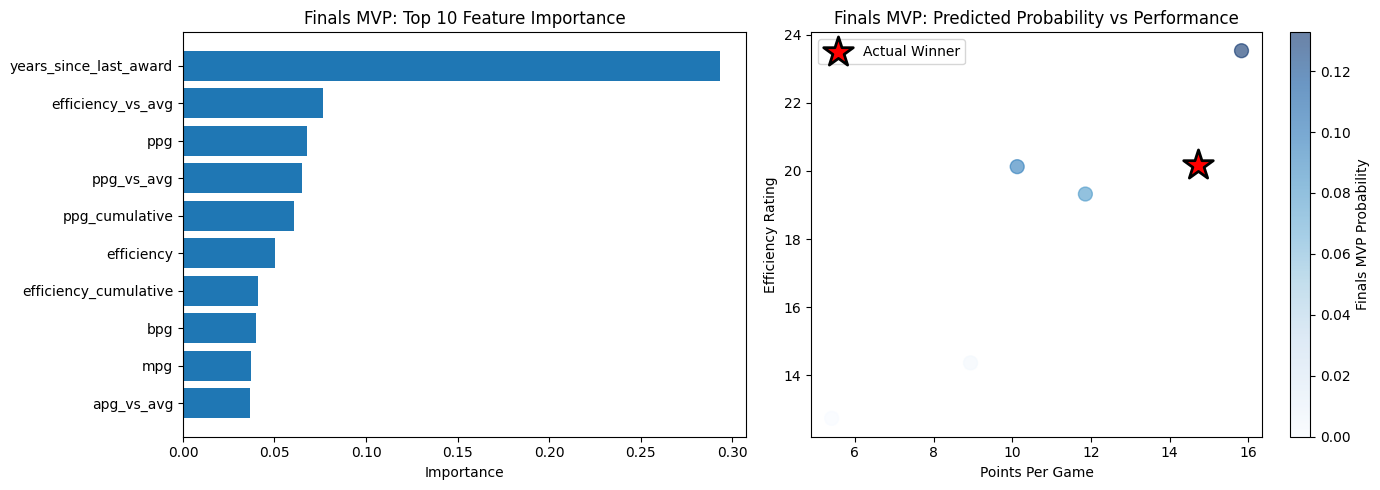


✅ FINALS MVP PREDICTION COMPLETE


In [171]:
# ===============================================================
# 🏆 WNBA FINALS MVP PREDICTION
# ===============================================================

target = 'won_wnba_finals_most_valuable_player'
target_year = 9

# ===============================================================
# 1️⃣ Eligibility Filtering
# ===============================================================

# note: must be on championship team (won_championship == 1)
train_finals = train_data[
    (train_data['won_championship'] == 1) &  # championship team only
    (train_data['GP'] >= 20) &  # significant playing time
    (train_data['mpg'] >= 15) &  # regular rotation player
    (train_data['year'] < target_year)  # training on years 1-8
].copy()

test_finals = player_df[
    (player_df['year'] == target_year) &
    (player_df['won_championship'] == 1) &
    (player_df['GP'] >= 20) &
    (player_df['mpg'] >= 15)
].copy()

print(f"// Finals MVP Eligible Players (excluding year 10):")
print(f"Training set: {len(train_finals)} eligible, {train_finals[target].sum()} winners")
print(f"Test set (year {target_year}): {len(test_finals)} eligible, {test_finals[target].sum()} winners")
print(f"Class balance (training): {train_finals[target].mean():.2%}")
print(f"Note: Year 10 excluded - playoffs haven't occurred yet")

# ===============================================================
# 2️⃣ Feature Selection (ENHANCED)
# ===============================================================
# Finals MVP: best player on championship team
features_fmvp = [
    # scorring and production
    'ppg', 'rpg', 'apg', 'spg', 'bpg',
    
    # efficiency and shooting
    'efficiency', 'fg_pct', 'mpg',
    
    # usage and role
    'GS', 'gs_pct',
    
    # comparative metrics (vs league average)
    'ppg_vs_avg', 'rpg_vs_avg', 'apg_vs_avg', 'efficiency_vs_avg',
    
    # team and playoff success
    'win_pct', 'conf_rank', 'playoff_wins',
    
    # cumulative features (career excellence)
    'ppg_cumulative', 'efficiency_cumulative', 'apg_cumulative',
    'rpg_cumulative',
    
    # award history (Finals often won by established stars)
    'total_previous_awards', 'years_since_last_award',
    'prev_wnba_finals_most_valuable_player',
    
    # experience (checking for veteran presence in championship moments)
    'years_experience'
]

x_train = train_finals[features_fmvp]
y_train = train_finals[target]
x_test = test_finals[features_fmvp]
y_test = test_finals[target]

print(f"\n// Feature set: {len(features_fmvp)} features (including {len([f for f in features_fmvp if 'cumulative' in f or 'prev' in f or 'previous' in f or 'experience' in f])} new historical features)")

# ===============================================================
# 3️⃣ Model Training
# ===============================================================
model_fmvp = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model_fmvp.fit(x_train, y_train)
print(f"\n// Model trained on {len(x_train)} players")

# ===============================================================
# 4️⃣ Predictions
# ===============================================================
test_finals = test_finals.copy()
test_finals.loc[:, 'fmvp_proba'] = model_fmvp.predict_proba(x_test)[:, 1]
test_finals.loc[:, 'fmvp_rank'] = test_finals['fmvp_proba'].rank(ascending=False, method='first')

# ===============================================================
# 5️⃣ Evaluation
# ===============================================================
actual_winner_id_array = test_finals[test_finals[target] == 1]['playerID'].values
if len(actual_winner_id_array) > 0:
    actual_winner_id = actual_winner_id_array[0]
    winner_rank = test_finals[test_finals['playerID'] == actual_winner_id]['fmvp_rank'].values[0]
    winner_proba = test_finals[test_finals['playerID'] == actual_winner_id]['fmvp_proba'].values[0]
    
    print(f"\n// Finals MVP Ranking Evaluation for year {target_year}:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_finals)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
    
    mrr = 1.0 / winner_rank
    print(f"Mean Reciprocal Rank: {mrr:.4f}")
else:
    print("\nNo Finals MVP winner in test set")

# ===============================================================
# 6️⃣ Top Finals MVP candidates
# ===============================================================
print("\n// Top 10 WNBA Finals MVP candidates:")
top_fmvp = test_finals[[
    'playerID', 'tmID', 'ppg', 'rpg', 'apg', 'efficiency',
    'mpg', 'playoff_wins', 'win_pct',
    'fmvp_proba', 'fmvp_rank', target
]].sort_values('fmvp_proba', ascending=False).head(10)
print(top_fmvp[['playerID', 'tmID', 'ppg', 'apg', 'efficiency', 'playoff_wins', 'fmvp_proba', 'fmvp_rank', target]])

# ===============================================================
# 7️⃣ Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'feature': features_fmvp,
    'importance': model_fmvp.feature_importances_
}).sort_values('importance', ascending=False)

print("\n// Top 10 Most Important Features for Finals MVP:")
for _, row in importance.head(10).iterrows():
    print(f"{row['feature']:30s} {row['importance']:.3f} {'█' * int(row['importance'] * 100)}")

# ===============================================================
# 8️⃣ Save Predictions
# ===============================================================
fmvp_pred = test_finals[['playerID', 'tmID', 'ppg', 'apg', 'rpg', 'efficiency', 
                         'win_pct', 'playoff_wins', 'fmvp_proba', 'fmvp_rank', target]].sort_values('fmvp_rank')
fmvp_pred.to_csv('data_models/predictions_fmvp.csv', index=False)
print(f"\n// Predictions saved to data_models/predictions_fmvp.csv")

# ===============================================================
# 9️⃣ Visualizations
# ===============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Feature Importance
axes[0].barh(importance.head(10)['feature'], importance.head(10)['importance'])
axes[0].set_xlabel('Importance')
axes[0].set_title('Finals MVP: Top 10 Feature Importance')
axes[0].invert_yaxis()

fmvp_winner = test_finals[test_finals[target] == 1]
fmvp_actual = test_finals[test_finals[target] == 0]

scatter = axes[1].scatter(fmvp_actual['ppg'], fmvp_actual['efficiency'], 
                         c=fmvp_actual['fmvp_proba'], cmap='Blues', alpha=0.6, s=100)
if len(fmvp_winner) > 0:
    axes[1].scatter(fmvp_winner['ppg'], fmvp_winner['efficiency'], 
                   c='red', marker='*', s=500, label='Actual Winner', edgecolors='black', linewidths=2)
axes[1].set_xlabel('Points Per Game')
axes[1].set_ylabel('Efficiency Rating')
axes[1].set_title('Finals MVP: Predicted Probability vs Performance')
axes[1].legend()
plt.colorbar(scatter, ax=axes[1], label='Finals MVP Probability')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✅ FINALS MVP PREDICTION COMPLETE")
print("="*60)

In [173]:
# ===============================================================
# 📋 SUMMARY OF ALL AWARD PREDICTIONS
# ===============================================================

print("="*70)
print(f"FINAL AWARD PREDICTIONS FOR YEAR {target_year}")
print("="*70)

mvp_pred = pd.read_csv("data_models/predictions_mvp.csv")
dpoy_pred = pd.read_csv("data_models/predictions_dpoy.csv")
roy_pred = pd.read_csv("data_models/predictions_roy.csv")
mip_pred = pd.read_csv("data_models/predictions_mip.csv")
asg_pred = pd.read_csv("data_models/predictions_asg.csv")
fmvp_pred = pd.read_csv("data_models/predictions_fmvp.csv")

mvp_winner = mvp_pred.nlargest(1, 'mvp_proba')
dpoy_winner = dpoy_pred.nlargest(1, 'dpoy_proba')
roy_winner = roy_pred.nlargest(1, 'roy_proba')
mip_winner = mip_pred.nlargest(1, 'mip_proba')
asg_winner = asg_pred.nlargest(1, 'asg_proba')
fmvp_winner = fmvp_pred.nlargest(1, 'fmvp_proba')

mvp_actual = mvp_pred[mvp_pred['won_most_valuable_player'] == 1]
dpoy_actual = dpoy_pred[dpoy_pred['won_defensive_player_of_the_year'] == 1]
roy_actual = roy_pred[roy_pred['won_rookie_of_the_year'] == 1]
mip_actual = mip_pred[mip_pred['won_most_improved_player'] == 1]
asg_actual = asg_pred[asg_pred['won_all-star_game_most_valuable_player'] == 1]
fmvp_actual = fmvp_pred[fmvp_pred['won_wnba_finals_most_valuable_player'] == 1]

print("\n// MOST VALUABLE PLAYER (Year 10):")
print(f"  Predicted: {mvp_winner['playerID'].values[0]}")
print(f"  Team: {mvp_winner['tmID'].values[0]}")
print(f"  PPG: {mvp_winner['ppg'].values[0]:.1f}")
print(f"  RPG: {mvp_winner['rpg'].values[0]:.1f}")
print(f"  APG: {mvp_winner['apg'].values[0]:.1f}")
print(f"  Confidence: {mvp_winner['mvp_proba'].values[0]:.1%}")
if len(mvp_actual) > 0:
    is_correct = mvp_winner['playerID'].values[0] == mvp_actual['playerID'].values[0]
    actual_rank = int(mvp_actual['mvp_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {mvp_actual['playerID'].values[0]}")

print("\n// DEFENSIVE PLAYER OF THE YEAR:")
print(f"  Predicted: {dpoy_winner['playerID'].values[0]}")
print(f"  Team: {dpoy_winner['tmID'].values[0]}")
print(f"  SPG: {dpoy_winner['spg'].values[0]:.1f}")
print(f"  BPG: {dpoy_winner['bpg'].values[0]:.1f}")
print(f"  RPG: {dpoy_winner['rpg'].values[0]:.1f}")
print(f"  Confidence: {dpoy_winner['dpoy_proba'].values[0]:.1%}")
if len(dpoy_actual) > 0:
    is_correct = dpoy_winner['playerID'].values[0] == dpoy_actual['playerID'].values[0]
    actual_rank = int(dpoy_actual['dpoy_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {dpoy_actual['playerID'].values[0]}")

print("\n// ROOKIE OF THE YEAR:")
print(f"  Predicted: {roy_winner['playerID'].values[0]}")
print(f"  Team: {roy_winner['tmID'].values[0]}")
print(f"  PPG: {roy_winner['ppg'].values[0]:.1f}")
print(f"  RPG: {roy_winner['rpg'].values[0]:.1f}")
print(f"  APG: {roy_winner['apg'].values[0]:.1f}")
print(f"  Confidence: {roy_winner['roy_proba'].values[0]:.1%}")
if len(roy_actual) > 0:
    is_correct = roy_winner['playerID'].values[0] == roy_actual['playerID'].values[0]
    actual_rank = int(roy_actual['roy_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {roy_actual['playerID'].values[0]}")

print("\n// MOST IMPROVED PLAYER:")
print(f"  Predicted: {mip_winner['playerID'].values[0]}")
print(f"  Team: {mip_winner['tmID'].values[0]}")
print(f"  PPG: {mip_winner['ppg'].values[0]:.1f} (Improvement: {mip_winner['ppg_improvement'].values[0]:+.1f})")
print(f"  Efficiency: {mip_winner['efficiency'].values[0]:.1f} (Improvement: {mip_winner['efficiency_improvement'].values[0]:+.1f})")
print(f"  Confidence: {mip_winner['mip_proba'].values[0]:.1%}")
if len(mip_actual) > 0:
    is_correct = mip_winner['playerID'].values[0] == mip_actual['playerID'].values[0]
    actual_rank = int(mip_actual['mip_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {mip_actual['playerID'].values[0]}")

print("\n// ALL-STAR GAME MVP:")
print(f"  Predicted: {asg_winner['playerID'].values[0]}")
print(f"  Team: {asg_winner['tmID'].values[0]}")
print(f"  PPG: {asg_winner['ppg'].values[0]:.1f}")
print(f"  RPG: {asg_winner['rpg'].values[0]:.1f}")
print(f"  APG: {asg_winner['apg'].values[0]:.1f}")
print(f"  Confidence: {asg_winner['asg_proba'].values[0]:.1%}")
if len(asg_actual) > 0:
    is_correct = asg_winner['playerID'].values[0] == asg_actual['playerID'].values[0]
    actual_rank = int(asg_actual['asg_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {asg_actual['playerID'].values[0]}")

print("\n// WNBA FINALS MVP:")
print(f"  Predicted: {fmvp_winner['playerID'].values[0]}")
print(f"  Team: {fmvp_winner['tmID'].values[0]}")
print(f"  PPG: {fmvp_winner['ppg'].values[0]:.1f}")
print(f"  RPG: {fmvp_winner['rpg'].values[0]:.1f}")
print(f"  APG: {fmvp_winner['apg'].values[0]:.1f}")
print(f"  Playoff Wins: {int(fmvp_winner['playoff_wins'].values[0])}")
print(f"  Confidence: {fmvp_winner['fmvp_proba'].values[0]:.1%}")
if len(fmvp_actual) > 0:
    is_correct = fmvp_winner['playerID'].values[0] == fmvp_actual['playerID'].values[0]
    actual_rank = int(fmvp_actual['fmvp_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {fmvp_actual['playerID'].values[0]}")

correct = 0
total = 0
if len(mvp_actual) > 0:
    correct += (mvp_winner['playerID'].values[0] == mvp_actual['playerID'].values[0])
    total += 1
if len(dpoy_actual) > 0:
    correct += (dpoy_winner['playerID'].values[0] == dpoy_actual['playerID'].values[0])
    total += 1
if len(roy_actual) > 0:
    correct += (roy_winner['playerID'].values[0] == roy_actual['playerID'].values[0])
    total += 1
if len(mip_actual) > 0:
    correct += (mip_winner['playerID'].values[0] == mip_actual['playerID'].values[0])
    total += 1
if len(asg_actual) > 0:
    correct += (asg_winner['playerID'].values[0] == asg_actual['playerID'].values[0])
    total += 1
if len(fmvp_actual) > 0:
    correct += (fmvp_winner['playerID'].values[0] == fmvp_actual['playerID'].values[0])
    total += 1

print("\n" + "="*70)
print(f"Overall Top-1 Accuracy: {correct}/{total} = {correct/total*100:.1f}%" if total > 0 else "No winners in test set")
print("="*70)
print("// All predictions complete!")

# ===============================================================
# 🎯 FINAL INSIGHT: Awards and Team Success
# ===============================================================
print("\n" + "="*70)
print("KEY INSIGHTS FROM THE BASKETBALL CONTEXT:")
print("="*70)

if len(mvp_actual) > 0:
    mvp_team_wins = mvp_actual['win_pct'].values[0]
    mvp_playoffs = mvp_actual['made_playoffs'].values[0]
    print(f"\n// MVP Winner's Team: {mvp_team_wins:.1%} win rate, {'made playoffs' if mvp_playoffs else 'missed playoffs'}")

if len(dpoy_actual) > 0:
    dpoy_team_wins = dpoy_actual['win_pct'].values[0]
    dpoy_playoffs = dpoy_actual['made_playoffs'].values[0]
    print(f"// DPOY Winner's Team: {dpoy_team_wins:.1%} win rate, {'made playoffs' if dpoy_playoffs else 'missed playoffs'}")

if len(roy_actual) > 0:
    roy_team_wins = roy_actual['win_pct'].values[0]
    roy_playoffs = roy_actual['made_playoffs'].values[0]
    print(f"// ROY Winner's Team: {roy_team_wins:.1%} win rate, {'made playoffs' if roy_playoffs else 'missed playoffs'}")

if len(mip_actual) > 0:
    mip_team_wins = mip_actual['win_pct'].values[0]
    mip_improvement = mip_actual['ppg_improvement'].values[0]
    print(f"// MIP Winner's Team: {mip_team_wins:.1%} win rate, PPG improvement: {mip_improvement:+.1f}")

if len(asg_actual) > 0:
    asg_team_wins = asg_actual['win_pct'].values[0]
    asg_ppg = asg_actual['ppg'].values[0]
    print(f"// All-Star MVP Winner's Team: {asg_team_wins:.1%} win rate, PPG: {asg_ppg:.1f}")

if len(fmvp_actual) > 0:
    fmvp_team_wins = fmvp_actual['win_pct'].values[0]
    fmvp_playoff_wins = int(fmvp_actual['playoff_wins'].values[0])
    print(f"// Finals MVP Winner's Team: {fmvp_team_wins:.1%} win rate, Playoff wins: {fmvp_playoff_wins}")

print("\n💡 As described in the project: teams with more wins qualify for playoffs.")
print("   Award winners are often from successful teams that make the playoffs.")
print("   Finals MVP always comes from the championship team.")
print("="*70)

# ===============================================================
# 🎯 COMPREHENSIVE MODEL EVALUATION
# ===============================================================
print("\n" + "="*70)
print("COMPREHENSIVE MODEL EVALUATION METRICS:")
print("="*70)

all_predictions = []
all_actuals = []
all_models = []

# MVP metrics
if len(mvp_actual) > 0:
    mvp_predicted_rank = int(mvp_actual['mvp_rank'].values[0])
    all_predictions.append(mvp_predicted_rank)
    all_actuals.append(1)
    all_models.append('MVP')
    
# DPOY metrics  
if len(dpoy_actual) > 0:
    dpoy_predicted_rank = int(dpoy_actual['dpoy_rank'].values[0])
    all_predictions.append(dpoy_predicted_rank)
    all_actuals.append(1)
    all_models.append('DPOY')
    
# ROY metrics
if len(roy_actual) > 0:
    roy_predicted_rank = int(roy_actual['roy_rank'].values[0])
    all_predictions.append(roy_predicted_rank)
    all_actuals.append(1)
    all_models.append('ROY')

# MIP metrics
if len(mip_actual) > 0:
    mip_predicted_rank = int(mip_actual['mip_rank'].values[0])
    all_predictions.append(mip_predicted_rank)
    all_actuals.append(1)
    all_models.append('MIP')

# All-Star MVP metrics
if len(asg_actual) > 0:
    asg_predicted_rank = int(asg_actual['asg_rank'].values[0])
    all_predictions.append(asg_predicted_rank)
    all_actuals.append(1)
    all_models.append('ASG')

# Finals MVP metrics
if len(fmvp_actual) > 0:
    fmvp_predicted_rank = int(fmvp_actual['fmvp_rank'].values[0])
    all_predictions.append(fmvp_predicted_rank)
    all_actuals.append(1)
    all_models.append('FMVP')

# Calculate aggregate metrics
if len(all_predictions) > 0:
    print("\n// Ranking Performance Metrics:")
    print(f"  Average Winner Rank: {np.mean(all_predictions):.2f}")
    print(f"  Median Winner Rank: {np.median(all_predictions):.1f}")
    print(f"  Best Rank: {np.min(all_predictions)}")
    print(f"  Worst Rank: {np.max(all_predictions)}")
    print(f"  Average MRR: {np.mean([1.0/r for r in all_predictions]):.4f}")
    
    print("\n// Success Rate by Top-K:")
    for k in [1, 3, 5, 10]:
        success_rate = np.mean([r <= k for r in all_predictions]) * 100
        print(f"  Top-{k:2d}: {success_rate:.1f}% ({int(success_rate * len(all_predictions) / 100)}/{len(all_predictions)} awards)")
    
    print("\n// Per-Award Performance:")
    for model, pred_rank in zip(all_models, all_predictions):
        mrr = 1.0 / pred_rank
        status = "✓" if pred_rank == 1 else "✗"
        print(f"  {model:4s}: Rank #{pred_rank:2d} | MRR={mrr:.4f} | {status}")

print("\n" + "="*70)


FINAL AWARD PREDICTIONS FOR YEAR 9

// MOST VALUABLE PLAYER (Year 10):
  Predicted: parkeca01w
  Team: LAS
  PPG: 18.5
  RPG: 9.5
  APG: 3.4
  Confidence: 42.5%
  Prediction: ✓ CORRECT
  Actual winner: parkeca01w

// DEFENSIVE PLAYER OF THE YEAR:
  Predicted: leslili01w
  Team: LAS
  SPG: 1.5
  BPG: 2.9
  RPG: 8.9
  Confidence: 24.0%
  Prediction: ✓ CORRECT
  Actual winner: leslili01w

// ROOKIE OF THE YEAR:
  Predicted: anosini01w
  Team: MIN
  PPG: 9.2
  RPG: 6.8
  APG: 1.3
  Confidence: 33.5%
  Prediction: ✗ INCORRECT (actual winner ranked #2)
  Actual winner: parkeca01w

// MOST IMPROVED PLAYER:
  Predicted: hoffmeb01w
  Team: IND
  PPG: 10.4 (Improvement: +6.1)
  Efficiency: 19.8 (Improvement: +10.9)
  Confidence: 61.0%
  Prediction: ✓ CORRECT
  Actual winner: hoffmeb01w

// ALL-STAR GAME MVP:
  Predicted: augusse01w
  Team: MIN
  PPG: 19.1
  RPG: 3.9
  APG: 2.7
  Confidence: 21.1%

// WNBA FINALS MVP:
  Predicted: smithka01w
  Team: DET
  PPG: 14.7
  RPG: 2.8
  APG: 4.0
  Playoff